# 绝热近似量子近似优化算法

## 01. 概述
本篇复现论文题目为《Digitized-counterdiabatic quantum approximate optimization algorithm》，发表在物理学期刊 PHYSICAL REVIEW RESEARCH，详细请看文献 [1]。

绝热近似量子近似优化算法（Digitized-counterdiabatic Quantum Approximate Optimization Algorithm，DC-QAOA）是利用"量子绝热捷径技术" 来改善量子近似优化算法的量子算法，具有物理启发性。在本文档里，比较了 QAOA 和 DC-QAOA算法来寻找最大割问题（Max-Cut) 哈密顿顿量的基态能量的收敛程度，我们发现 DC-QAOA算法能更好的找到基态能量。 本文档可以用来熟悉MindQuantum中量子线路的搭建和训练。

## 02. 环境准备

In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX, RZ, RY
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import mindspore.nn as nn
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from IPython.display import Image

/home/ma-user/modelarts-dev/modelarts-sdk/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


## 03. DC-QAOA算法整体流程


1. QAOA算法的量子线路由两部分组成。\
一部分是参数化量子线路，另一部分由经典优化通过定义的损失函数来优化量子线路中的参数。量子线路的哈密顿量是一个退火哈密顿量形式
$$
H(t) = (1-\lambda(t))H_{mixer}  + \lambda(t)H_{prob}
$$
其中 $\lambda\in[0,1]$，$H_{mixer}=\sum_ih_i\sigma_i^x$。系统的初态处在 $H_{mixer}$ 的基态上，通过绝热过程最终演化到定义的问题哈密顿量 $H_{prob}$ 的基态上。 可以使用 trotterized 时间演化算子设计相应的数字绝热量子线路
$$
U(0,T) \approx \prod_{j=1}^p\prod_{m=1}^M{\rm exp}\{-iH_m(j\Delta t)\Delta t \}
$$
其中 $H(t)$ 可以分解为 $M$ 个局域项。将 $U(0,T)$ 转换为 QAOA 的语言  
$$
U(\beta,\gamma) = U_m(\beta_p)U_p(\gamma_p)U_m(\beta_{\gamma_{p-1}})\cdots U_m(\beta_1)U_p(\gamma_1)
$$
其中演化算符 $U_m(\beta_p)={\rm exp}(-i\beta_p H_{mixer})$, $U_p(\gamma_p)={\rm exp}(-i\gamma_p H_{prob})$。量子线路中的参数 $(\gamma,\beta)$ 为 $\{\beta_p, \beta_{p-1}, \cdots, \beta_1\}$，总共有 2p 个参数，参数空间的大小对应着量子线路的深度。
经典优化器最小化损失函数 $C(\gamma,\beta)$ 得到优化参数 $\gamma^*, \beta^*$。值得注意的是，在大多数情况下目标态非常接近问题哈密顿量的基态 $H_{prob}$。

2. 量子绝热捷径技术包括 counterdiabatic (CD) driving, fast-forward approach, 和 invariant- based inverse engineering 等，其能加速绝热演化的过程。在中本文用 counterdiabatic (CD) driving 方法，绝热势能定义如下[2]
$$
A_\lambda^{(l)} = i\sum_{k=1}^l\alpha_k(t)\mathop{\underbrace{[H_a, [H_a,\cdots[H_\alpha}}\limits_{2k-1},\partial_\lambda H_a]]]
$$
如果仅仅考虑 $l=2$，算符$A$的可能有 $A=\{\sigma^y,\sigma^z\sigma^y,\sigma^y\sigma^z,\sigma^x\sigma^y,\sigma^y\sigma^x\}$,这些算符仅仅是两体相互作用。\
量子线路中 CD 部分的演化为
$$
U(CD)_{\alpha}=\prod_{j=1}^Le^{-i\alpha A^{q}_t}
$$
其中 $A^{q}_t$ 代表第 $q$ 个局域绝热算符。

## 04.搭建 QAOA 与 DC-QAOA 量子线路
QAOA量子线路的搭建过程在Mindquantum教程里有详细的介绍，请看[3], 与QAOA量子线路不同的是，DC-QAOA根据绝热量子捷径技术增加了抑制系统在绝热演化过程的抗激发项，是基于物理启发设计的量子线路。

In [3]:
def build_ansatz(qubit, p, g, J, problem, CD):
    """
    qubit: 输入量子比特的数目
    p: 量子线路的层数
    g: max cut 的图
    J: 哈密顿量子项前的系数，如果是-1需要 Rz 门, 1,ZZ 门
    problem: 根据问题 "Max_cut" 或者 "SK_model" 产生不同的哈密顿量
    CD: True/False
    """
    circ = Circuit()
    # problem hamitonian
    if problem == "Max_cut":
        for i in range(p):
            #-------- problem hamitonian ------
            for index, z in enumerate(g.edges):
                circ += ZZ(f'g').on(z)
            #-------- mix hamitonian-----------
            for z in range(qubit):
                circ += RX(f'b').on(z)  
            #-------- CD hamitonian-----------
            if CD == True:
                for index, z in enumerate(g.edges):
                    circ += RX(np.pi/2).on(z[1])
                    circ += ZZ(f'CD{i}').on(z) 
                    circ += RX(-np.pi/2).on(z[1]) 
                
    if problem == "SK_model":
        for i in range(p):
            #-------- problem hamitonian ------
            for index, z in enumerate(g.edges):
                if J[index] == 1:
                    circ += ZZ(f'g{i}').on(z)
                else:
                    circ += RZ(f'd{i}').on(z[0])   
            #-------- mix hamitonian-----------
            for z in range(qubit):
                circ += RX(f'b').on(z)   
            #-------- CD hamitonian-----------
            if CD == True:
                for index, z in enumerate(g.edges):
                    circ += RY(f'CD{i}').on(z[1])   
    return circ

## 05. 构建问题哈密顿量
max cut 和 SK 模型问题哈密顿量均为
$$
H = \sum_{ij}J_{ij}\sigma_i^z\sigma_j^z
$$
本文中考虑的是 3-regular MaxCut problem, 其中 $J_{ij}=1$。对于 SK 模型，$J=\{1,-1\}$  概率各为 1/2。

In [4]:
# 搭建哈密顿量。
def build_ham(g, J):
    """
    g: max cut 的图
    J: 哈密顿量子项前的系数
    """
    ham = QubitOperator()
    for index, i in enumerate(g.edges):
        ham += J[index]*QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

## 06. 通过求解矩阵的本征值，获得最低能量。
在本文中因为要计算通过量子线路求解的哈密顿量的近似基态能量和准确基态能量的比值，所以我们需要求解哈密顿量矩阵的本征值。\
假设经过优化后，DC-QAOA 线路的量子态为 $|\psi(\gamma^*,\beta^*,\alpha^*)\rangle$, 那么哈密顿量的近似基态能量为
$$
E(\gamma^*,\beta^*,\alpha^*) = \langle\psi(\gamma^*,\beta^*,\alpha^*)|H_{prob}|
\psi(\gamma^*,\beta^*,\alpha^*)\rangle
$$
我们可以计算近似基态能量与准确基态能量比值
$$
\mathcal{R} = \frac{E(\gamma^*,\beta^*,\alpha^*)}{E_0}
$$
其中 $E_0$ 是系统的基态

In [5]:
def get_expectation_of_hamitonian(circ, qubit, ham, pr):

    sim = Simulator('mqvector', qubit)
    sim.apply_circuit(circ, pr)
    result = sim.get_expectation(ham)
    # energy[k] = result.real
        
    return result.real

def E0_energy(ham_operator):
    
    # 首先根据哈密顿量的算符将其转化为矩阵形式。
    ham_matrix = ham_operator.matrix()
    ham_matrix = ham_matrix.todense()

    # calculate the eigenvalue and eigenvector
    eigval, eigvec = np.linalg.eig(ham_matrix)

    # ground energy
    E0 = min(eigval).real
    
    return E0

## 07. 训练参数化量子线路
首先根据不同的问题搭建好参数化量子线路，利用 Mindspore 里的优化器进行参数优化，在这里我们使用使用Adagrad算法进行梯度优化，迭代次数为300次，并返回参数化量子线路和最优参数。


In [6]:
def train(g, qubit, p, J, ham, problem, CD):
    """
    g: max cut 的图
    qubit: 输入量子比特的数目
    p: 线路的层数
    J: 哈密顿量子项前的系数，如果是-1需要 Rz 门, 1,ZZ 门
    ham: 问题哈密顿量
    problem:  "Max_cut" 或者 "SK_model" 
    DC: True/False
    """
    
    # bulid the quantum circuit
    init_state_circ = UN(H, qubit)                                  # 生成均匀叠加态，即对所有量子比特作用H门
    if problem == "Max_cut":
        
        if CD == True: 
            ansatz = build_ansatz(qubit, p, g, J, problem, True)   # 生成 DC-QAOA-ansatz线路
        else:
            ansatz = build_ansatz(qubit, p, g, J, problem, False)  # 生成 QAOA-ansatz线路
            
    if problem == "SK_model":
        
        if CD == True:
            ansatz = build_ansatz(qubit, p, g, J, problem, True)   # 生成 DC-QAOA-ansatz线路
        else:
            ansatz = build_ansatz(qubit, p, g, J, problem, False)  # 生成 QAOA-ansatz线路
    
    circ = init_state_circ + ansatz                                # 将初始化线路与ansatz线路组合成一个线路
    # optimize the parameters
    sim = Simulator('mqvector', circ.n_qubits)   
    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    net = MQAnsatzOnlyLayer(grad_ops)                             
    opti = nn.Adagrad(net.trainable_params(), learning_rate=0.1)     
    train_net = nn.TrainOneStepCell(net, opti)                    


    for i in range(300):
        train_net()                                            # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    
    pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))   # 获取线路参数
        
    return circ, pr

## 08.Max 问题

In [8]:
qubits = [4, 6, 8, 10, 12]

# 计算10个不同 3-Regular MaxCut

instance = 10
Approxi_ratio = [0]*instance*len(qubits)
Approxi_ratio_cd = [0]*instance*len(qubits)

k = 0
#不同的量子比特
p = 1 # 1层量子线路
for qubit in tqdm(qubits):
    # 取10中不同的 3-Regular MaxCut 图
    for i in range(instance):

        
        maxcut_graph=nx.random_regular_graph(n=qubit, d = 3)         # 产生随机的 3-Regular MaxCut 图
        J = [1]*len(maxcut_graph.edges())
        ham_operator = build_ham(maxcut_graph,J)              # 根据图得到对应的哈密顿量算符
        E0 = E0_energy(ham_operator)                                # 计算哈密顿量的基态能量
        ham = Hamiltonian(ham_operator)                             # 生成哈密顿量
     
        #---------------------------------------------------
        # 通过 QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p, J, ham, "Max_cut", False)
        expectation = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio[k] = expectation/E0
        
        #---------------------------------------------------
        # 通过 DC-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p, J, ham, "Max_cut", True)
        expectation_2 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_cd[k] = expectation_2/E0
        k += 1

100%|██████████| 5/5 [06:49<00:00, 81.87s/it] 


## 绘制图像

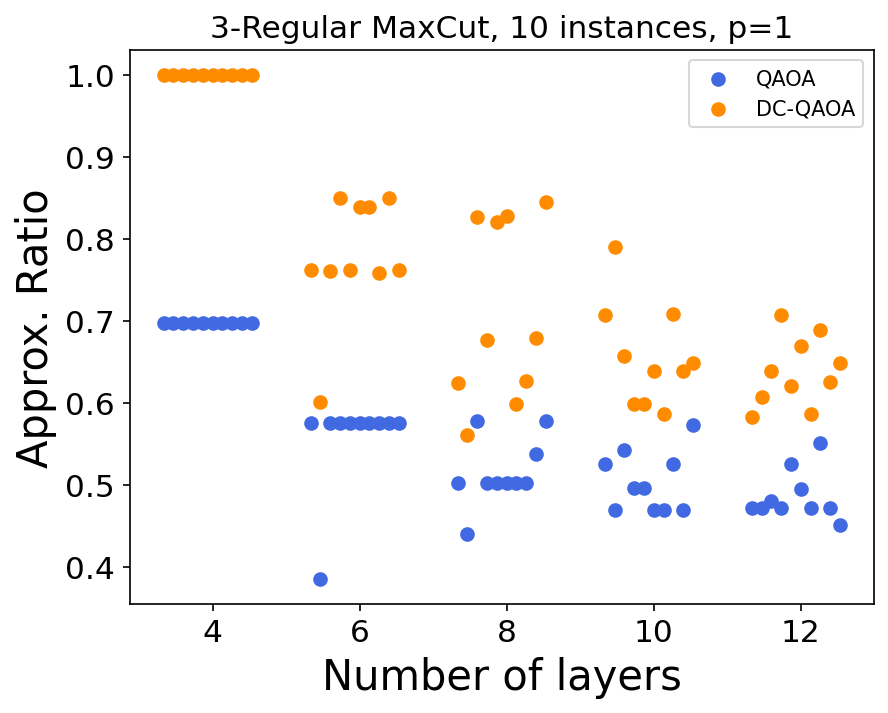

In [9]:
plt.figure(1, dpi=150)
for i in range(5):

    plt.scatter(range(15*i,15*i+10), Approxi_ratio[10*i:10*(i+1)] , color='royalblue', label="QAOA")
    plt.scatter(range(15*i,15*i+10), Approxi_ratio_cd[10*i:10*(i+1)], color='darkorange', label="DC-QAOA")
    plt.xticks([5, 20, 35, 50, 65], ['4','6', '8', '10', '12'], fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Approx. Ratio', fontsize=20)
    plt.xlabel('Number of layers', fontsize=20)
    plt.title("3-Regular MaxCut, 10 instances, p=1", fontsize=15)
    if i == 0:
        plt.legend(fontsize=10)
plt.show()

## 09. SK 模型

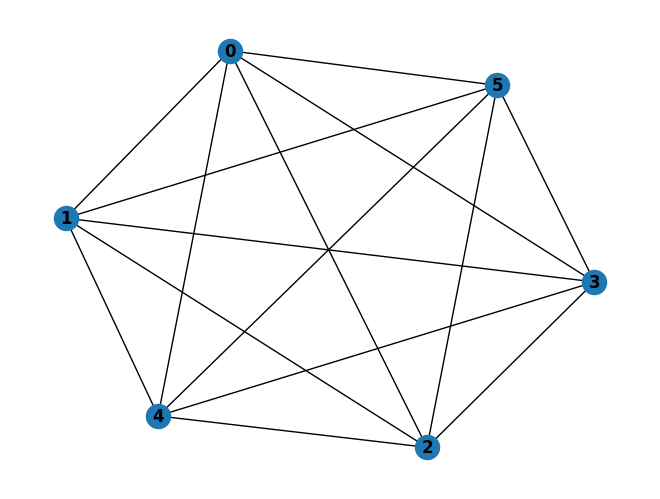

In [45]:
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [1, 2])
nx.add_path(g, [2, 3])
nx.add_path(g, [3, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [0, 5])
nx.add_path(g, [1, 3])
nx.add_path(g, [1, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 2])
nx.add_path(g, [2, 4])
nx.add_path(g, [2, 5])
nx.add_path(g, [0, 3])
nx.add_path(g, [3, 5])
nx.add_path(g, [0, 4])
nx.draw(g, with_labels=True, font_weight='bold')

plt.show()

In [53]:
qubit = 6
SK_instance = 10
layer = [1,2, 3,4,5]
Approxi_ratio = np.zeros((SK_instance, len(layer)))
Approxi_ratio_cd = np.zeros((SK_instance, len(layer)))
    
for i in tqdm(range(SK_instance)):

    J = [np.random.choice([-1,1]) for _ in range(len(g.edges))]   # 随机生成 -1, 1
    ham_operator = build_ham(g, J)                                # 根据图得到对应的哈密顿量算符
    ham = Hamiltonian(ham_operator)                               # 生成哈密顿量
    E0 = E0_energy(ham_operator)                                # 计算哈密顿量的基态能量
    
    for p in layer:
        
        #---------------------------------------------------
        # 通过 QAOA 计算基态能量
        circ, pr = train(g, qubit, p, J, ham, "SK_model", False)
        expectation = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        Approxi_ratio[i,p-1] = expectation/E0

        #---------------------------------------------------
        # 通过 DC-QAOA 计算基态能量
        circ, pr = train(g, qubit, p, J, ham, "SK_model", True)
        expectation2 = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        Approxi_ratio_cd[i,p-1] = expectation2/E0

Approxi_ratio_mean = Approxi_ratio.mean(axis=0)
Approxi_ratio_cd_mean = Approxi_ratio_cd.mean(axis=0)

100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


## 绘制图像

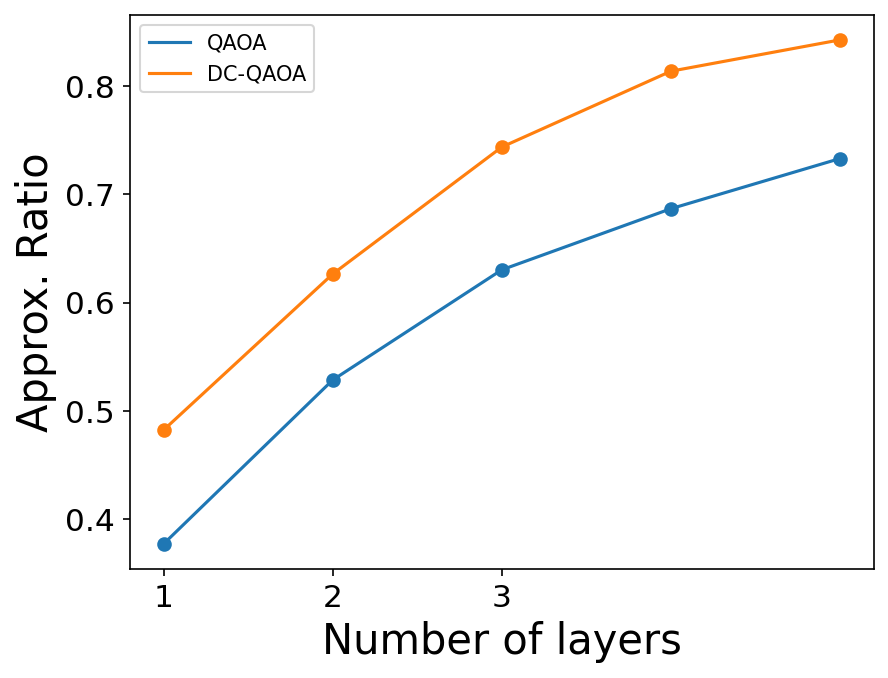

In [54]:
plt.figure(1, dpi=150)
plt.plot(range(1,len(layer)+1),Approxi_ratio_mean, label="QAOA")
plt.scatter(range(1,len(layer)+1),Approxi_ratio_mean)
plt.plot(range(1,len(layer)+1),Approxi_ratio_cd_mean, label="DC-QAOA")
plt.scatter(range(1,len(layer)+1),Approxi_ratio_cd_mean)
#plt.ylim(0.2, 1)
plt.xticks([1,2,3],['1','2', '3'], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Approx. Ratio', fontsize=20)
plt.xlabel('Number of layers', fontsize=20)
plt.legend(fontsize=15)
plt.legend()
plt.show()

##  参考文献
【1】P. Chandarana, N. N. Hegade, K. Paul, F. Albarrán-Arriagada, E. Solano, A. del Campo, and Xi Chen, Digitized-counterdiabatic quantum approximate optimization algorithm, Phys. Rev. Research 4, 013141 (2022).\
【2】P. W. Claeys, M. Pandey, D. Sels, and A. Polkovnikov, Floquet- engineering counterdiabatic protocols in quantum many-body systems, Phys. Rev. Lett. 123, 090602 (2019).\
【3】https://hiq.huaweicloud.com/portal/programming/jupyterLab?fileName=quantum_approximate_optimization_algorithm